# Анализ данных

In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

## Изучение данных

Далее представлено несколько колонок полученного набора данных.

In [2]:
data = pd.read_parquet("ml_test_rec_sys.parquet")
data.head()

,UserID,GameTitle,Rating,Age,Gender,Location,Device,PlayTimeOfDay,TotalPlaytimeInHours,PurchaseHistory,InvolvementLevel,UserReview,GameGenre,GameUpdateFrequency,SocialActivity,LoadingTimeInSeconds,GameSettingsPreference
0,user_1,game_1,2,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,RPG,Frequent,Active,16,High Graphics
1,user_1,game_2,5,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Sports,Frequent,Low,30,High Performance
2,user_1,game_3,2,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Adventure,Occasional,Low,40,High Graphics
3,user_1,game_4,3,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,RPG,Occasional,Moderate,24,High Graphics
4,user_1,game_5,5,50,Male,North America,Mobile,Night,48,Yes,Beginner,Negative,Action,Occasional,Active,50,Balanced


Не нашел в репозитории описания данных, поэтому, опишу как я интерпретировал таблицу, для того чтобы читающему было понятнее по какой причине я принял те или иные решения.

Удельная запись представляест собой пары комбинаций пользователь-игра и соответсвнно описание пользовательского опыта в той или иной игре.

### Описание колонок

Очевидно что:

- `UserID` - уникальный идентификатор пользователя;
- `GameTitle` - уникальный идетификатор игры;
- `Age` - возраст пользователя;
- `Gender` - пол пользователя;
- `PurchaseHistory` - если история покупок у этого пользователя;
- `GameGenre` - жанр рассматриваемой игры;
- `GameUpdateFrequency` - как часто обновляется данная игра;
- `GameSettingsPreference` - некоторая особенность игры.

Для некоторых колонок не до конца понятно описывают они пользователя (одинаковые в рамках пользоваля), игру (одинаковые в рамках игры) или описывают выбранную комбинацию пользователь игра (то есть потенциально могут быть уникальными вне привязки к пользователю или игре).

Так например колонка `Rating` может описывать средний рейтинг по игре или быть отражением того, что так ее оценил пользователь который сопряжен с ней в этой записи.

Для того чтобы проверить такие моменты, для каждого пользователя/игры подсчитаем сколько уникальных значений соответсвуют ему в той или иной колонке. В следующей ячейке проводится эта процедура - в результате для каждой колонки поставлено в соответсвие уникальные ли в ней значения по пользователю и по игре.

In [3]:
display(HTML("<b>По пользователю</b>"))
by_user = (
    (data.groupby("UserID").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
by_game = (
    (data.groupby("GameTitle").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
pd.DataFrame({
    "По пользователю" : by_user,
    "По игре" : by_game
}).loc[data.columns]

,По пользователю,По игре
UserID,NaN,Не уникальное
GameTitle,Не уникальное,NaN
Rating,Не уникальное,Не уникальное
Age,Уникальное,Не уникальное
Gender,Уникальное,Не уникальное
Location,Уникальное,Не уникальное
Device,Уникальное,Не уникальное
PlayTimeOfDay,Уникальное,Не уникальное
TotalPlaytimeInHours,Уникальное,Не уникальное
PurchaseHistory,Уникальное,Не уникальное


Можно сделать выводы про следующие колонки:

- `Rating` указывает как клиент из записи оценил соовтевующую игру;
- `Location` указывает на условно постоянный адрес пользоватля (а не то куда он играл в ту или иную игру);
- `Device` указывает на условно постоянный девайс пользователя (а не то каой девайс он исопльзовал для игры);
- `PlayTimeOfDay` указывает когда клиент предпочитает играть - уникальный по пользователю;
- `TotalPlaytimeInHours` то сколько **всего** играл пользователь во все игры, а не то соколько он играл именно в эту игру;
- `InvolvementLevel` - то насколько пользователь вовлечен в игровую платформу в целом а не в конкретную игру;
- `UserReview` - отзыв пользователя, видимо ко всей платформе в целом а не к конкретной игре;
- `SocialActivity` - не до конца понятно что это за колонка но это какая-то уникальная характеристика игры;
- `LoadingTimeInSeconds` - сколько данная игра загружалась, получается что у всех пользователей игра зпускается одинаково быстро.

**Целевая переменная**

Совершенно очевидно, что в данном случае следует использовать переменную `Rating` как целевую переменную (target) так как только она характеризует некотрое свойсво комбинации пользователь/игра, Все остальные переменны характеризую либо некоторого пользователя либо некоторую игру.

### Гипотезы

Возможно женщинам и мужчинам нравятся разные игровые жанры. Поэтому подсчитаем раличные статистики по рейтингу в сопряженности пола и игрового жанра.

In [4]:
my_gb = data.groupby(["Gender", "GameGenre"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2920,4015,1460,2555,2555,3650,1095
Male,2520,3465,1260,2205,2205,3150,945
Other,2560,3520,1280,2240,2240,3200,960


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2.994178,3.037360,2.939041,2.971820,3.008611,3.003288,3.044749
Male,2.994841,2.990765,2.949206,3.013605,3.016780,2.984444,3.082540
Other,3.010937,3.001705,3.013281,2.973214,3.008482,2.992812,2.984375


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,0.198630,0.201743,0.192466,0.199609,0.199217,0.200548,0.207306
Male,0.194444,0.194228,0.184921,0.200000,0.205896,0.193968,0.220106
Other,0.202734,0.203693,0.204687,0.194643,0.209375,0.194062,0.194792


Можно подумать, что мобильные платформы не такие производительные как стационарные поэтому стоит перепроверить может не стоит на мобилы рекомендовать высокопроизводительные игры. Закономерностей не обнаружено.  

In [5]:
my_gb = data.groupby(["GameSettingsPreference", "Device"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,3924,4032,4044
High Graphics,7194,7392,7414
High Performance,5232,5376,5392


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,2.994139,3.001984,3.010386
High Graphics,2.981790,3.021645,3.004181
High Performance,2.959098,2.989955,3.036165


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,0.200306,0.200893,0.199060
High Graphics,0.194746,0.202922,0.197194
High Performance,0.189220,0.201079,0.210497


Предположения опирающиеся на бизнес смысл переменных не дают никакого результата. Пойдем от обратного. Попробуем построить простенькую, легко интерпретируемую модельку и посмотрим на результат. Возьмем, например, не глубокое решающее дерево и попробуем из его решений выловить закономерности. В следующей ячейке подогнано и визуализировано решающее дерево. Похоже, анализ среднего рейтинга нидает никакого внятного результата.

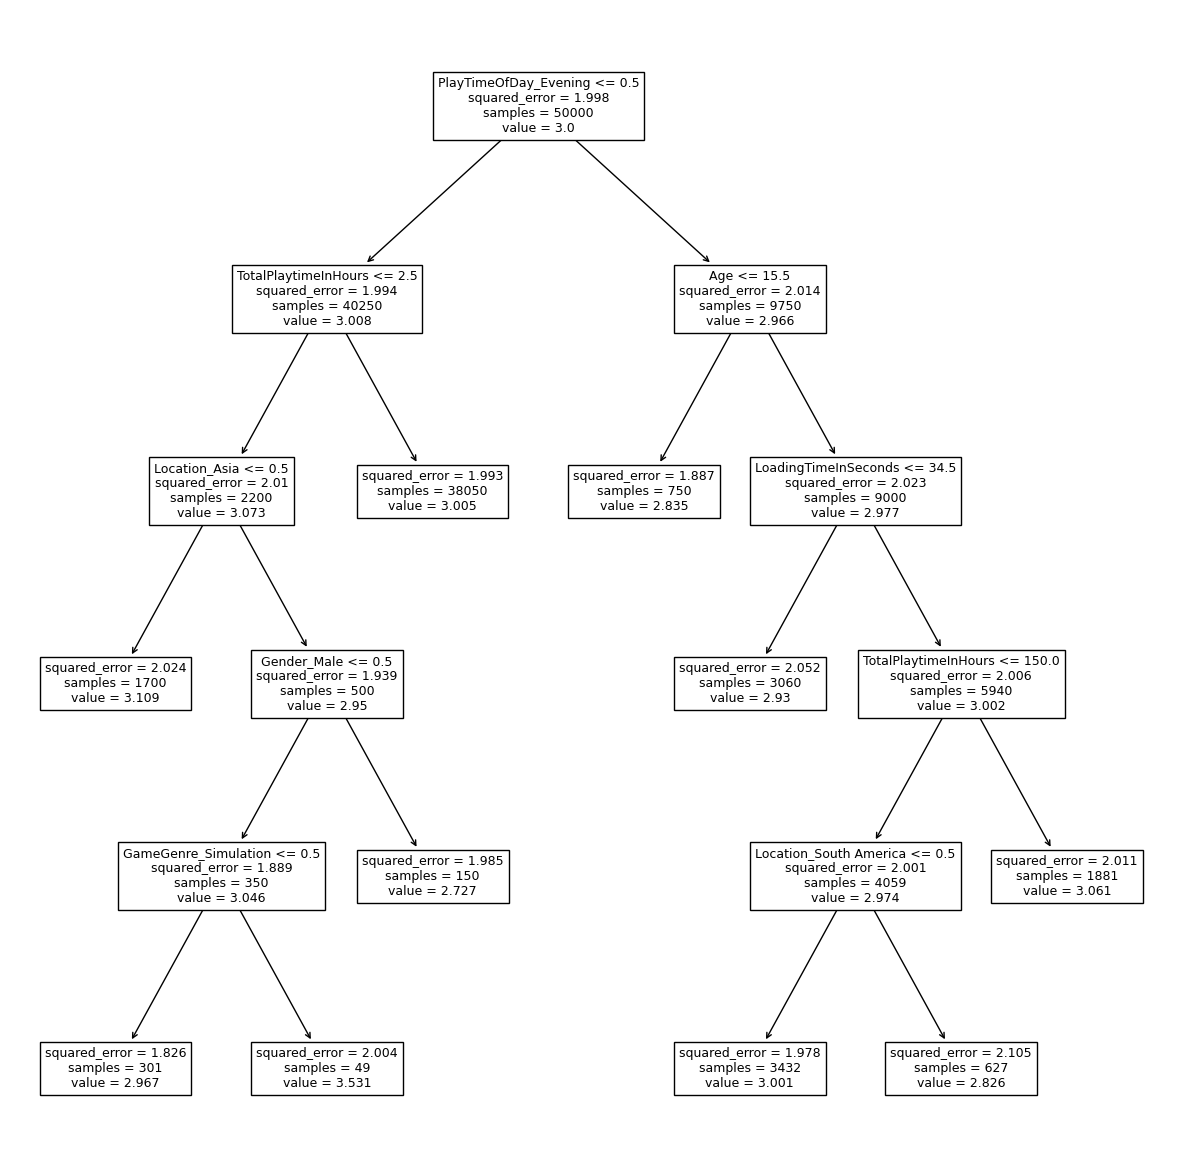

In [6]:
X = data.drop(["UserID", "GameTitle", "Rating"], axis = 1)
X = pd.get_dummies(X, drop_first=True)
y = data["Rating"]

clf = tree.DecisionTreeRegressor(max_leaf_nodes = 10)
clf.fit(X, y)

plt.figure(figsize = [15,15])
tree.plot_tree(clf, feature_names=X.columns)
plt.show()

## Выбор переменных

In [7]:
data.select_dtypes("number").describe()

,Rating,Age,TotalPlaytimeInHours,LoadingTimeInSeconds
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.000280,40.059000,96.810000,53.480000
std,1.413591,17.501418,93.622771,30.114245
min,1.000000,10.000000,1.000000,11.000000
25%,2.000000,25.000000,11.000000,30.000000
50%,3.000000,40.000000,50.000000,51.000000
75%,4.000000,55.000000,177.000000,76.000000
max,5.000000,70.000000,299.000000,117.000000


In [8]:
data.select_dtypes("O").describe()

,UserID,GameTitle,Gender,Location,Device,PlayTimeOfDay,PurchaseHistory,InvolvementLevel,UserReview,GameGenre,GameUpdateFrequency,SocialActivity,GameSettingsPreference
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,1000,50,3,6,3,4,2,4,3,7,3,3,3
top,user_1000,game_1,Female,South America,PC,Night,No,Expert,Positive,Adventure,Occasional,Active,High Graphics
freq,50,1000,18250,9100,16850,19450,34600,13300,17600,11000,18000,22000,22000


## Подготовка модели

In [9]:
X = data.drop(["UserID", "GameTitle", "Rating"], axis = 1)
y = data["Rating"]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size = 0.8, random_state = 10)

In [10]:
my_model = Pipeline([
    ("encoder", OneHotEncoder()),
    ("model", RandomForestRegressor(max_depth=50, n_estimators=20))
])

In [11]:
my_model.fit(X_train, y_train)

Pipeline(steps=[('encoder', OneHotEncoder()),
                ('model',
                 RandomForestRegressor(max_depth=50, n_estimators=20))])

In [12]:
predict_test = pd.Series(my_model.predict(X_test), index=X_test.index)

In [13]:
temp = data.loc[X_test.index, ["UserID", "GameTitle", "Rating"]]
temp["predict"] = predict_test
temp.groupby("UserID").apply(lambda subset: subset.loc[subset["predict"].idxmax(), "Rating"]).value_counts()

/tmp/ipykernel_10017/2868742173.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp.groupby("UserID").apply(lambda subset: subset.loc[subset["predict"].idxmax(), "Rating"]).value_counts()


3    206
1    205
4    202
2    198
5    189
Name: count, dtype: int64

In [14]:
data["Rating"].value_counts()

Rating
4    10050
3    10006
1    10002
2     9972
5     9970
Name: count, dtype: int64

In [15]:
temp

,UserID,GameTitle,Rating,predict
27632,user_553,game_33,3,3.086376
36119,user_723,game_20,1,2.690678
4796,user_96,game_47,2,2.860679
3648,user_73,game_49,1,2.923014
24501,user_491,game_2,3,2.905599
...,...,...,...,...
39432,user_789,game_33,5,2.946991
9566,user_192,game_17,5,3.091956
8894,user_178,game_45,5,3.026618
39283,user_786,game_34,2,2.554475
